Group Project Proposal

Introduction:
We are using data on the top 500 tennis players. We will try to predict a player's prize money based on variables such as rank, number of seasons, height, and number of titles. 
The dataset we will be using is "Player Stats for Top 500 Players" from https://www.ultimatetennisstatistics.com/. 

In [39]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)

In [43]:

player_stats<-read_csv("player_stats.csv")
player_stats


Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



X1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [63]:
colnames(player_stats) <- make.names(colnames(player_stats))

#removing useless characters in 
player_stats$Prize.Money<-gsub("\\$","",as.character(player_stats$Prize.Money))
player_stats$Prize.Money<-gsub("US","",as.character(player_stats$Prize.Money))
player_stats$Prize.Money<-gsub("\\$ ","",as.character(player_stats$Prize.Money))
player_stats$Prize.Money<-gsub("all-time leader in earnings","",as.character(player_stats$Prize.Money))
player_stats$Prize.Money<-gsub("All-time leader in earnings","",as.character(player_stats$Prize.Money))
player_stats$Prize.Money<-gsub(",","",as.character(player_stats$Prize.Money))

player_stats_tidy <- player_stats%>%
    separate(
        col = Prize.Money,
        into = c("Prize.Money", "All.Time.Rank"),
        sep = " ", 
    ) %>%
    separate(
        col = Age,
        into = c("Age", "DOB"),
        sep = " ", 
    ) %>%
    separate(
        col = Best.Rank,
        into = c("Best.Rank", "Best.Rank.Date"),
        sep = " ", 
    ) %>%
    separate(
        col = Current.Rank,
        into = c("Current.Rank1", "Current.Rank2"),
        sep = " ", 
    ) 
    
view<- player_stats_tidy%>%
    select(Prize.Money,All.Time.Rank)

head(view,275)

player_stats_tidy

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [16, 96, 128, 142, 208, 212, 267, 274, 337, 363, 364, 381, 394, 414, 423, 435, 436, 461, 468, 497].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 383 rows [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, ...].”


Prize.Money,All.Time.Rank
<chr>,<chr>
NA,NA
59040,NA
3261567,NA
⋮,⋮
723271,NA
,139144944
250932,NA


X1,Age,DOB,Country,Plays,Wikipedia,Current.Rank1,Current.Rank2,Best.Rank,Best.Rank.Date,⋯,Facebook,Twitter,Nicknames,Grand.Slams,Davis.Cups,Web.Site,Team.Cups,Olympics,Weeks.at.No..1,Tour.Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26,(25-04-1993),Brazil,Right-handed,Wikipedia,378,(97),363,(04-11-2019),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18,(22-12-2001),United Kingdom,Left-handed,Wikipedia,326,(119),316,(14-10-2019),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32,(03-11-1987),Slovakia,Right-handed,Wikipedia,178,(280),44,(14-01-2013),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23,(14-03-1996),Netherlands,Left-handed,Wikipedia,495,(60),342,(05-08-2019),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24,(17-05-1995),Ukraine,NA,Wikipedia,419,(81),419,(20-01-2020),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22,(26-03-1997),Tunisia,Left-handed,Wikipedia,451,(69),408,(24-12-2018),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Warning message:
“Removed 106 rows containing missing values (geom_point).”


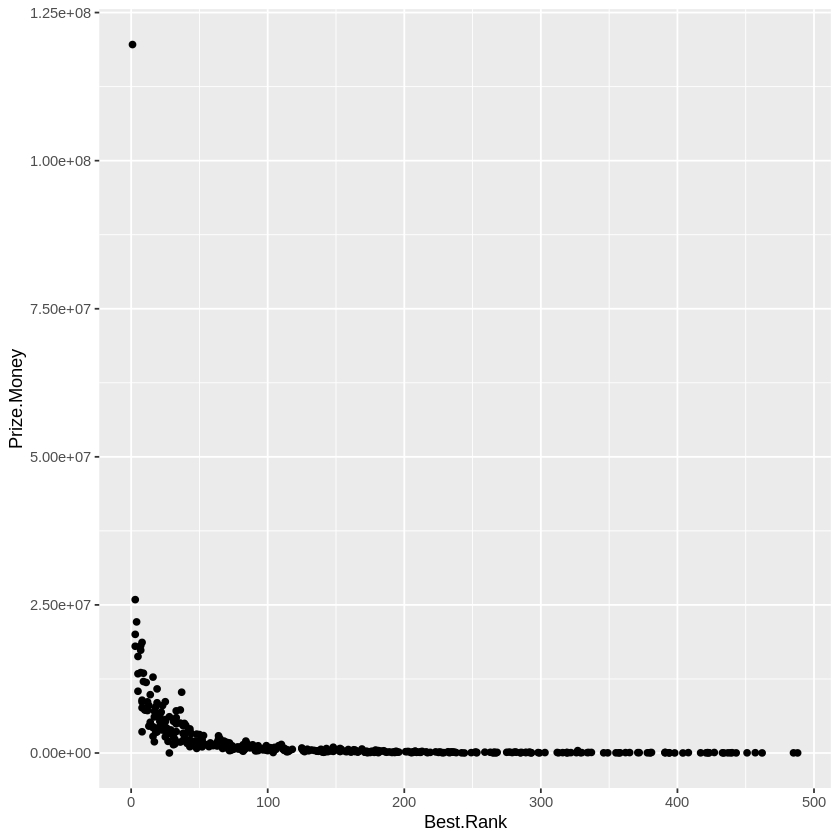

In [67]:
plot<-player_stats_tidy%>%
    mutate(Best.Rank=as.numeric(Best.Rank, na.rm=T), Prize.Money=as.numeric(Prize.Money, na.rm=T))%>%
    ggplot(aes(x=Best.Rank, y=Prize.Money))+
        geom_point()
plot

In [39]:
x1<-sample(c("Male1","Female1"),20,replace=TRUE)
x2<-rpois(20,5)
df1<-data.frame(x1,x2)
df1
df1$x1<-gsub("1","",as.character(df1$x1))
df1

x1,x2
<chr>,<int>
Male1,5
Male1,4
Female1,10
⋮,⋮
Male1,8
Male1,0
Male1,4


x1,x2
<chr>,<int>
Male,5
Male,4
Female,10
⋮,⋮
Male,8
Male,0
Male,4


Methods:
We will use the columns "Current Rank", "Best Rank", "Height", "Seasons", "Best Elo Rank", "Peak Elo Rating", and "Titles" to predict a player's prize money. 
To conduct our analysis, we will first filter our data to remove any empty cells in our columns of interest.
We will then separate the data into the training and testing portions.
Then we will create a recipe and use k nearest neighbors to predict a player's prize money. 
We will visualize results by creating a plot of prize money against each of these variables seperately.

Expected outcomes:
We expect to see that higher ranked players will be making more prize money, as well as players that have been playing for more seasons. 
We are unsure how height will be related to prize money, but this could be an interesting relationship to explore, and could lead to other questions about factors like weight or muscle mass affecting prize money. 